# MASSIVE PROBLEM NOW NEED TO SAVE THE TOKENISER TO MAKE THE CODE FULLY REPRODUCIBLE.

## ALSO I HAVE CHANGED THE TRAINING AND CODE SO THAT NEEDS CHANGING BACK!

In [1]:
from pathlib import Path

import sys
sys.path.insert(0, str(Path('..').resolve()))

import copy
from collections import defaultdict
from pathlib import Path
from typing import Optional, List, Tuple, Callable, Dict, Any

import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
%matplotlib inline

from bella.error_analysis import same_one_sentiment, same_multi_sentiment,\
                                 similar_sentiment, different_sentiment, unknown_targets
from bella.evaluation import datasets_df, plot_acc_f1, summary_errors
from bella.parsers import semeval_14, semeval_15_16
from bella.preprocessing import tokeniser
from bella.tokenisers import stanford
from bella.word_embeddings import GloveCommonEmbedding
from bella.dataloaders import TargetSequence, LeftRightTargetSequence, LeftRightAugmentSequence, TargetAugmentation
from bella import keras_models
from bella.data_types import TargetCollection

Using TensorFlow backend.


In [2]:
def dataset_word_list(tokeniser, *datasets):
    words = []
    for dataset in datasets:
        words.extend(dataset.word_list(tokeniser))
    return list(set(words))

# Load the data
## Restaurants
rest_sem_dir = Path('..', '..', 'aspect datasets', 'semeval_2014')
rest_train = semeval_14(Path(rest_sem_dir, 'restaurants_train.xml'))
rest_test = semeval_14(Path(rest_sem_dir, 'restaurants_test.xml'))

rest_train_fp, rest_dev_fp = rest_train.to_json_file(['restaurants train', 'restaurants dev'], 
                                                     0.2, cache=False, random_state=42)
rest_test_fp = rest_test.to_json_file('restaurants test', cache=False)
## Laptop
laptop_sem_dir = Path('..', '..', 'aspect datasets', 'semeval_2014')
laptop_train = semeval_14(Path(rest_sem_dir, 'laptop_train.xml'))
laptop_test = semeval_14(Path(rest_sem_dir, 'laptop_test.xml'))

laptop_train_fp, laptop_dev_fp = laptop_train.to_json_file(['laptop train', 'laptop dev'], 
                                                     0.2, cache=False, random_state=42)
laptop_test_fp = laptop_test.to_json_file('laptop test', cache=False)

# Load the embeddings
## Need to create a tokeniser that maps words to embedding id first
rest_tok = tokeniser(rest_train_fp, rest_dev_fp, rest_test_fp, 
                     tokeniser_function=stanford, 
                     lower=True, filters='', oov_token='<UNK>')
glove_rest = GloveCommonEmbedding(840, rest_tok.word_index)

laptop_tok = tokeniser(laptop_train_fp, laptop_dev_fp, laptop_test_fp, 
                       tokeniser_function=stanford, 
                       lower=True, filters='', oov_token='<UNK>')
glove_laptop = GloveCommonEmbedding(840, laptop_tok.word_index)

rest_fps = [rest_train_fp, rest_dev_fp, rest_test_fp]
laptop_fps = [laptop_train_fp, laptop_dev_fp, laptop_test_fp]
domain_data = {'laptop': (laptop_fps, laptop_tok, glove_laptop), 
               'restaurant': (rest_fps, rest_tok, glove_rest)}

In [3]:
rest_tok.word_index

{'<UNK>': 1,
 'the': 2,
 ',': 3,
 '.': 4,
 'and': 5,
 'a': 6,
 'is': 7,
 'to': 8,
 'was': 9,
 'food': 10,
 'of': 11,
 'i': 12,
 'for': 13,
 'with': 14,
 'in': 15,
 'it': 16,
 'service': 17,
 'you': 18,
 'are': 19,
 'great': 20,
 'we': 21,
 'but': 22,
 'good': 23,
 'that': 24,
 '(': 25,
 'not': 26,
 ')': 27,
 'they': 28,
 'on': 29,
 'have': 30,
 'had': 31,
 'at': 32,
 'this': 33,
 'were': 34,
 'very': 35,
 "n't": 36,
 "'s": 37,
 'place': 38,
 'as': 39,
 '-': 40,
 'my': 41,
 '!': 42,
 'so': 43,
 'be': 44,
 'menu': 45,
 'all': 46,
 'from': 47,
 'an': 48,
 'like': 49,
 'wine': 50,
 'our': 51,
 'if': 52,
 'or': 53,
 'there': 54,
 'their': 55,
 'excellent': 56,
 'delicious': 57,
 'best': 58,
 'get': 59,
 'staff': 60,
 '$': 61,
 'out': 62,
 'one': 63,
 'fresh': 64,
 'pizza': 65,
 'restaurant': 66,
 'nice': 67,
 'prices': 68,
 'has': 69,
 'when': 70,
 'dinner': 71,
 'chicken': 72,
 'us': 73,
 'by': 74,
 'do': 75,
 'dishes': 76,
 'atmosphere': 77,
 'your': 78,
 'some': 79,
 'no': 80,
 'been': 8

In [17]:
rest_tok.word_index

{'<UNK>': 1,
 'the': 2,
 ',': 3,
 '.': 4,
 'and': 5,
 'a': 6,
 'is': 7,
 'to': 8,
 'was': 9,
 'food': 10,
 'of': 11,
 'i': 12,
 'for': 13,
 'with': 14,
 'in': 15,
 'it': 16,
 'service': 17,
 'you': 18,
 'are': 19,
 'great': 20,
 'we': 21,
 'but': 22,
 'good': 23,
 'that': 24,
 '(': 25,
 'not': 26,
 ')': 27,
 'they': 28,
 'on': 29,
 'have': 30,
 'had': 31,
 'at': 32,
 'this': 33,
 'were': 34,
 'very': 35,
 "n't": 36,
 "'s": 37,
 'place': 38,
 'as': 39,
 '-': 40,
 'my': 41,
 '!': 42,
 'so': 43,
 'be': 44,
 'menu': 45,
 'all': 46,
 'from': 47,
 'an': 48,
 'like': 49,
 'wine': 50,
 'our': 51,
 'if': 52,
 'or': 53,
 'there': 54,
 'their': 55,
 'excellent': 56,
 'delicious': 57,
 'best': 58,
 'get': 59,
 'staff': 60,
 'out': 61,
 '$': 62,
 'one': 63,
 'fresh': 64,
 'pizza': 65,
 'restaurant': 66,
 'nice': 67,
 'prices': 68,
 'has': 69,
 'when': 70,
 'dinner': 71,
 'us': 72,
 'chicken': 73,
 'do': 74,
 'by': 75,
 'dishes': 76,
 'atmosphere': 77,
 'your': 78,
 'some': 79,
 'no': 80,
 'even': 8

In [3]:
import json
from bella.data_types import Target
rest_dev = []
with rest_dev_fp.open('r') as fp:
    for line in fp:
        target_dict = json.loads(line)
        target_dict['spans'][0] = tuple(target_dict['spans'][0])
        rest_dev.append(Target(**target_dict))
rest_dev = TargetCollection(rest_dev)

We want to test the affect of Target information in LSTM based models specifically TDLSTM and TCLSTM models of [Tang et al.](https://arxiv.org/abs/1512.01100), for context the TDLSTM model splits the sentence in two contexts the left and right context of the Target word within the text. The left context ends at the right most target word and the right context ends at the left most target word(s). An LSTM encodes the left hand side and a **Backward** LSTM enocodes the right hand side. The idea behind having the Target word(s) as the last word in the LSTM model is so that the model better captures the Target information. The TCLSTM model is an extension of TDLSTM where at each timestep which is a word the information given to the LSTM is the word embedding of that timestep as well as the Target word embedding.

1. Position (POS) -- As both models do not encode the full sentence each but encode the Left and Right seperately the LSTM model in essence knows the position of the Target words which is the first type of Target information **Position**.
2. Target within text (TWT) -- Both the TDLSTM and TCLSTM, LSTM's last timesteps take are the Target word(s) therefore this is the second type of Target information
3. Target At Each Timestep (TAET) -- The TCLSTM LSTM's take as input the word embedding of the timesteps word as well as the Target's embedding this is the third type of Target information.

Therefore we are now going to see which combination if not all performs the best. Within the original paper they belive that the TCLSTM model that encodes all three was best but this was shown not to always be the case. Also the original paper never looked at the affect of not having TWT. The combinations we are going to look at are below:
1. POS -- Never looked at before
2. POS + TWT -- Original TDLSTM method
3. POS + TAET -- Never looked at before
4. POS + TWT + TAET -- Original TCLSTM

In [4]:
def train_val_test_loader(dataloader_class: Sequence,
                          domain_data: Tuple[List[Path], Tokenizer, GloveCommonEmbedding], 
                          **loader_kwargs) -> List[Sequence]:
    data_fps, tok, _ = domain_data
    train_fp, val_fp, test_fp = data_fps
    train = dataloader_class(train_fp, 32, tok, stanford, 
                             sort_field='text', **loader_kwargs)
    no_transformers = copy.deepcopy(loader_kwargs)
    if 'transformers' in no_transformers:
        no_transformers.pop('transformers')
    val = dataloader_class(val_fp, 32, tok, stanford, 
                           sort_field=None, **no_transformers)
    test = dataloader_class(test_fp, 32, tok, stanford, 
                            sort_field=None, **no_transformers)
    return train, val, test

def save_and_predict(model: Model, train: Sequence, val: Sequence, test: Sequence, 
                     model_path: Path, predict_path: Path, epochs: int = 100):
    model_path.parent.mkdir(parents=True, exist_ok=True)
    predict_path.parent.mkdir(parents=True, exist_ok=True)
    
    
    if predict_path.suffix == '':
        predict_path = predict_path.with_suffix('.npy')
    temp_model_path = model_path
    if temp_model_path.suffix == '':
        temp_model_path = temp_model_path.with_suffix('.index')
    if temp_model_path.exists() and predict_path.exists():
        return np.load(predict_path)
    print(model_path)
    
    model_path = str(model_path.resolve())
    history = keras_models.fit(model, train, val, model_path, verbose=1, 
                               use_multiprocessing=True, workers=4, epochs=epochs)
    print(history)
    predictions = model.predict_generator(test, use_multiprocessing=True, workers=4)
    predictions = np.argmax(predictions, axis=1)
    # Map the sentiment back to its original labels
    sent_conv = {2: 1, 1: 0, 0: -1}
    predictions = np.array([sent_conv[pred] for pred in predictions])
    np.save(predict_path, predictions)
    
    return predictions

def model_creation(model_creation_func, dataloader_class, domain_data, model_path,
                   predict_path, num_copies, dataloader_kwargs=None, **model_creation_kwargs):
    model_copies = []
    if dataloader_kwargs is None:
        dataloader_kwargs = {}
    for copy_num in range(num_copies):
        predict_path_name = f'{predict_path.name} {copy_num}'
        temp_predict_path = predict_path.with_name(predict_path_name)
        model_path_name = f'{model_path.name} {copy_num}'
        temp_model_path = model_path.with_name(model_path_name)
        
        train, val, test = train_val_test_loader(dataloader_class, 
                                                 domain_data, **dataloader_kwargs)
        domain_embeddings = domain_data[2] 
        model = model_creation_func(domain_embeddings.embedding, **model_creation_kwargs)
        model_copies.append((model, train, val, test, temp_model_path,
                             temp_predict_path))
    return model_copies

def multi_save_and_predict(model_settings, model_dir, predict_dir,
                           domain_data, pred_dict, num_times=30, 
                           dataloader_class=LeftRightTargetSequence,
                           **model_kwargs):
    for model_type_name, dataloader_kwargs, model_name in model_settings:
        model_type_dir = Path(model_dir, model_type_name)
        predict_type_dir = Path(predict_dir, model_type_name)

        for domain_name, data in domain_data.items():
            model_type_path = Path(model_type_dir, f'normal {domain_name}')
            predict_type_path = Path(predict_type_dir, f'normal {domain_name}')

            model_func = getattr(keras_models, model_name)
            model_args = model_creation(model_func, dataloader_class, 
                                        data, model_type_path, predict_type_path, num_times, 
                                        dataloader_kwargs=dataloader_kwargs,
                                        **model_kwargs)
            for model_arg in model_args:
                print(model_type_path)
                import datetime
                print(datetime.datetime.now())
                predictions = save_and_predict(*model_arg)
                pred_dict[model_type_name][domain_name].append(predictions)
    return pred_dict

def return_save_data(model_settings, model_dir, predict_dir, num_copies,
                     pred_dict, domain_data):
    '''
    If the data has been saved will return a dictionary of all of the 
    saved data else it will return False.
    '''
    for model_type_name, _, _ in model_settings:
        model_type_dir = Path(model_dir, model_type_name)
        predict_type_dir = Path(predict_dir, model_type_name)

        for domain_name, _ in domain_data.items():
            model_type_path = Path(model_type_dir, f'normal {domain_name}')
            predict_type_path = Path(predict_type_dir, f'normal {domain_name}')
            
            for copy_num in range(num_copies):
                predict_path_name = f'{predict_type_path.name} {copy_num}'
                temp_predict_path = predict_type_path.with_name(predict_path_name)
                model_path_name = f'{model_type_path.name} {copy_num}'
                temp_model_path = model_type_path.with_name(model_path_name)
                
                temp_model_path.parent.mkdir(parents=True, exist_ok=True)
                temp_predict_path.parent.mkdir(parents=True, exist_ok=True)
    
    
                if temp_predict_path.suffix == '':
                    temp_predict_path = temp_predict_path.with_suffix('.npy')
                if temp_model_path.suffix == '':
                    temp_model_path = temp_model_path.with_suffix('.index')
                if temp_model_path.exists() and temp_predict_path.exists():
                    predictions = np.load(temp_predict_path)
                    pred_dict[model_type_name][domain_name].append(predictions)
                    continue
                return False
    return pred_dict

def domain_predictions(model_domain_preds, domain):
    '''
    Returns only the domain predictions
    '''
    
    model_predictions = {}
    for model, domain_predictions in model_domain_preds.items():
        for domain_name, predictions in domain_predictions.items():
            if domain_name == domain:
                model_predictions[model] = predictions
    return model_predictions

def dict_to_collection(model_preds, domain_dataset):
    model_collections = []
    for model, preds in model_preds.items():
        data = domain_dataset.data()
        model_collection = TargetCollection(data, name=model)
        model_collection.add_pred_sentiment(np.array(preds).T)
        model_collections.append(model_collection)
    return model_collections

def model_results_prob(result_collections: TargetCollection,
                       metrics: List[Tuple[str, 
                                     Callable[[np.ndarray, np.ndarray], 
                                             float]]],
                       metric_funcs_kwargs: Optional[Dict[str, 
                                                          Dict[str, Any]]] = None
                      ) -> pd.DataFrame:
    dfs = []
    for collection in result_collections:
        name = collection.name
        temp_name = name
        lower_name = name.lower()
        probability = 0
        if 'probability' in lower_name:
            probability = float(lower_name.split()[-1])
            temp_name = name.split()[0]
        collection.name = temp_name
        additional_data = {temp_name: {'Probability': probability}}
        df = datasets_df([collection], metrics, metric_funcs_kwargs, 
                         additional_data)
        collection.name = name
        dfs.append(df)
    return pd.concat(dfs)

In [5]:
model_dir = Path('..', 'Data Augmentation', 'Models')
predict_dir = Path('..', 'Data Augmentation', 'Predictions')


model_domain_predictions = defaultdict(lambda: defaultdict(list))

model_settings = [('POS', {'include_target_in_batches': False,
                           'include_target_in_sequence': False},
                   'tdlstm'), 
                  ('TWT', {'include_target_in_batches': False},
                   'tdlstm'), 
                  ('TAET', {'include_target_in_sequence': False}, 
                   'tclstm'), 
                  ('TWT_TAET', None, 'tclstm')]

data_saved = return_save_data(model_settings, model_dir,
                              predict_dir, 30, model_domain_predictions,
                              domain_data)
if not data_saved:
    model_domain_predictions = multi_save_and_predict(model_settings, model_dir, 
                                                      predict_dir, domain_data, 
                                                      model_domain_predictions)

For the TCLSTM method as it uses TAET this target embedding can have it's own embedding layer rather than at the moment it being shared with the words from the left and right context. The reason this might be desirable is so that the Target information is to some extent seperately encoded so that similar targets are closer together before being merged with the sentiment information.

Therefore we are going to train the:
1. POS + TAET
2. POS + TWT + TAET

So that these models first embeded the TAET in a seprate word embedding before being concatenated to the words these models will be called:
1. POS + TAET + E
2. POS + TWT + TAET + E

In [6]:
model_settings = [('TAET_E', {'include_target_in_sequence': False}, 
                   'tclstm'), 
                  ('TWT_TAET_E', None, 'tclstm')]

data_saved = False
data_saved = return_save_data(model_settings, model_dir,
                              predict_dir, 30, model_domain_predictions,
                              domain_data)
if not data_saved:
    for domain_name, data in domain_data.items():
        temp_domain_data = {f'{domain_name}': data}
        domain_embedding = data[2].embedding
        model_domain_predictions = multi_save_and_predict(model_settings, model_dir, 
                                                          predict_dir, temp_domain_data, 
                                                          model_domain_predictions,
                                                          target_embedding=domain_embedding)

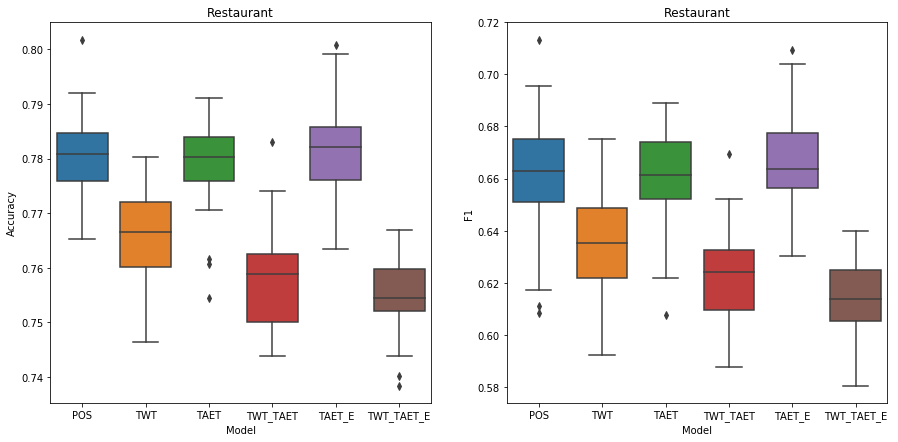

In [7]:
restaurant_predictions = domain_predictions(model_domain_predictions, 'restaurant')
laptop_predictions = domain_predictions(model_domain_predictions, 'laptop')
restaurant_collections = dict_to_collection(restaurant_predictions, rest_test)
laptop_collections = dict_to_collection(laptop_predictions, laptop_test)

metrics = [('Accuracy', accuracy_score), ('F1', f1_score)]
metric_kwargs = {'F1': {'average': 'macro'}}
rest_results = datasets_df(restaurant_collections, metrics, metric_kwargs)
laptop_results = datasets_df(laptop_collections, metrics, metric_kwargs)

fig = plot_acc_f1(rest_results, 'Restaurant', figsize=(15, 7))
fig.savefig('Restaurant Original Results.png')

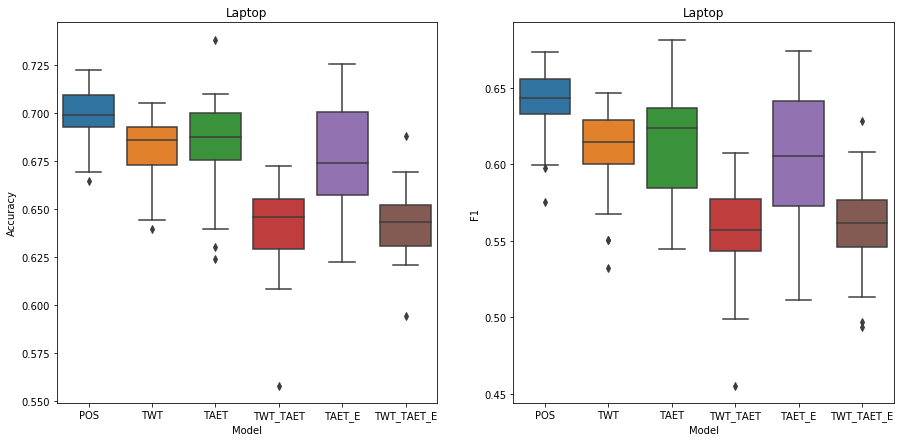

In [8]:
plot_acc_f1(laptop_results, 'Laptop', figsize=(15, 7))
fig.savefig('Laptop Original Results.png')

As we can see from the results above the less target information incorporated into the model the better it is for the model espically for the Laptop domain. For the Restaurant domain it would appear to be just as benifical to have a Target At Each Timestep as not.

Below we poke into the results further by sub-dividing the samples from the test dataset into 5 categories:
1. Same One -- Where the samples contain a target that has been associated to one sentiment which is the same in train and test. 
2. Same Multi -- Where the samples contain a target that has been associtaed to more than one sentiment but the same sentiments in both train and test sets.
3. Similar -- Where the samples contain a target that has been associated to more than one sentiment and there is overlap in these sentiments between train and test but they are never identical.
4. Different -- Where the samples contain a target that has been associated to sentiments that occur only in train but never test.
5. Unknown -- Up to now all targets have been seen in train and test. In this case the targets never occur in the train set only in test.

Before showing the results for these categories we shall show the distributions of these categories over the two datasets:

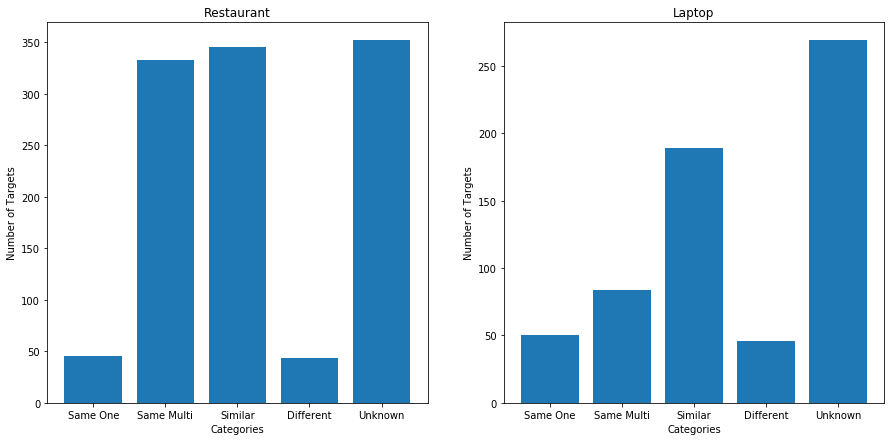

In [9]:
error_funcs = [('Same One', same_one_sentiment), ('Same Multi', same_multi_sentiment),
               ('Similar', similar_sentiment), ('Different', different_sentiment),
               ('Unknown', unknown_targets)]

name_test_trains = [('Restaurant', rest_test, rest_train), ('Laptop', laptop_test, laptop_train)]
fig, axs = plt.subplots(1, len(name_test_trains), figsize=(15, 7))
for index, name_test_train in enumerate(name_test_trains):
    name, test, train = name_test_train
    num_targets = [len(func(test, train)) for _, func in error_funcs]
    x = range(1, len(num_targets) + 1)
    
    ax = axs[index]
    ax.bar(x, num_targets)
    ax.set_title(name)
    ax.set_xlabel('Categories')
    ax.set_ylabel('Number of Targets')
    x_ticks = ['']
    x_ticks.extend([cat_name for cat_name, _ in error_funcs])
    ax.set_xticklabels(x_ticks)


As we can see above the distributions of these categories are different for the two domains. Both have small representation for the `Same One` and `Different` but both have large representation for the `Unknown` category.

In [10]:
metrics = [('Acc', accuracy_score)]
error_func_kwargs = {error_name: {'train_dataset': rest_train} for error_name, _ in error_funcs}

print('Results for the Restaurant domain for the 5 categories listed above.')
summary_errors(restaurant_collections, metrics=metrics,
               error_funcs=error_funcs, error_funcs_kwargs=error_func_kwargs, std_err=True)

Results for the Restaurant domain for the 5 categories listed above.


,Same One,Same Multi,Similar,Different,Unknown
,Acc,Acc,Acc,Acc,Acc
POS,84.96 (3.75),82.19 (1.49),77.53 (1.06),66.82 (3.69),75.14 (1.17)
TWT,95.78 (2.83),80.85 (1.35),78.31 (1.66),53.71 (5.43),71.33 (1.29)
TAET,95.78 (2.83),82.05 (1.28),78.64 (1.41),56.52 (3.60),73.63 (1.39)
TWT_TAET,95.93 (2.08),79.43 (1.32),78.18 (1.47),47.35 (6.24),71.05 (1.22)
TAET_E,95.41 (2.87),82.01 (1.08),78.91 (1.60),52.42 (4.50),74.86 (1.33)
TWT_TAET_E,96.07 (2.12),79.39 (1.25),77.84 (1.51),42.65 (4.76),70.97 (1.26)


In [11]:
print('Results for the Laptop domain for the 5 categories listed above.')
summary_errors(laptop_collections, metrics=metrics,
               error_funcs=error_funcs, error_funcs_kwargs=error_func_kwargs, std_err=True)

Results for the Laptop domain for the 5 categories listed above.


,Same One,Same Multi,Similar,Different,Unknown
,Acc,Acc,Acc,Acc,Acc
POS,100.00 (0.00),72.89 (5.69),77.89 (6.71),75.00 (0.00),69.38 (1.54)
TWT,100.00 (0.00),78.89 (7.11),71.05 (5.88),76.25 (3.75),67.52 (1.89)
TAET,93.33 (24.94),74.22 (5.90),71.93 (6.97),78.75 (5.73),67.79 (2.72)
TWT_TAET,86.67 (33.99),74.67 (7.38),65.26 (7.39),75.00 (8.54),63.56 (2.34)
TAET_E,93.33 (24.94),74.89 (5.36),73.68 (6.08),78.33 (6.40),67.14 (3.01)
TWT_TAET_E,90.00 (30.00),72.00 (6.30),65.61 (7.66),79.58 (8.83),63.84 (1.80)


We can see stright away there is a different in results between the domains. In the restaurant domain as we add more target information into the model the results get better for the same `Same One` category and worse for the `Different` but the opposite happens within the Laptop domain. We expect these results for the restaurant domain as the more target information we get the more it could overfit to the target and hence perform better for the `Same One` and worse for the `Different`.

The second interesting factor which is the same accross domain the more target information the worse it gets for the `unknown` category which is by far the most important category for the Laptop domain.

# Target Augmentation

In [12]:
# We create a mapping of targets to related targets
rest_15_sem_dir = Path('/home/andrew/Documents/ABSA15_RestaurantsTrain')
rest_15_train = semeval_15_16(Path(rest_15_sem_dir, 'ABSA-15_Restaurants_Train_Final.xml'), 
                              raise_error_no_category=True, sep_15_from_14=True)

rest_cat_targets, _ = rest_15_train.categories_targets()
rest_targets = rest_train.target_set()
target_to_targets = rest_train.target_targets(rest_targets, rest_cat_targets)

Filtered 1 categories which are:
FOOD#GENERAL


In [13]:
rest_only = {'restaurant': domain_data['restaurant']}
#model_domain_predictions = defaultdict(lambda: defaultdict(list))

probabilities = [0.2, 0.5, 0.7, 1]
for probability in probabilities:
    model_dir = Path('..', 'Data Augmentation', f'Models Probability {probability}')
    predict_dir = Path('..', 'Data Augmentation', f'Predictions Probability {probability}')
    
    target_trans = TargetAugmentation(target_to_targets, probability=probability)
    model_settings = [(f'TAET Probability {probability}', 
                       {'include_target_in_sequence': False,
                        'transformers': [target_trans]}, 
                       'tclstm'),
                      (f'TWT Probability {probability}', 
                       {'include_target_in_batches': False, 
                        'transformers': [target_trans]},
                       'tdlstm'),
                      (f'TWT_TAET Probability {probability}', 
                       {'transformers': [target_trans]}, 
                       'tclstm'),
                      (f'TAET_E Probability {probability}', 
                       {'include_target_in_sequence': False, 
                        'transformers': [target_trans]},
                       'tclstm'),
                      (f'TWT_TAET_E Probability {probability}', 
                       {'transformers': [target_trans]}, 
                       'tclstm')]
    
    data_saved = return_save_data(model_settings, model_dir, predict_dir, 10,
                                  model_domain_predictions, rest_only)
    if data_saved:
        continue
    
    
    model_domain_predictions = multi_save_and_predict(model_settings, model_dir, 
                                                      predict_dir, rest_only, 
                                                      model_domain_predictions,
                                                      num_times=10, 
                                                      dataloader_class=LeftRightAugmentSequence)

../Data Augmentation/Models Probability 1/TAET Probability 1/normal restaurant
2018-10-24 23:11:30.972662
../Data Augmentation/Models Probability 1/TAET Probability 1/normal restaurant
2018-10-24 23:11:30.974912
../Data Augmentation/Models Probability 1/TAET Probability 1/normal restaurant
2018-10-24 23:11:30.976614
../Data Augmentation/Models Probability 1/TAET Probability 1/normal restaurant
2018-10-24 23:11:30.978196
../Data Augmentation/Models Probability 1/TAET Probability 1/normal restaurant
2018-10-24 23:11:30.979867
../Data Augmentation/Models Probability 1/TAET Probability 1/normal restaurant
2018-10-24 23:11:30.981509
../Data Augmentation/Models Probability 1/TAET Probability 1/normal restaurant
2018-10-24 23:11:30.983164
../Data Augmentation/Models Probability 1/TAET Probability 1/normal restaurant
2018-10-24 23:11:30.984800
../Data Augmentation/Models Probability 1/TAET Probability 1/normal restaurant
2018-10-24 23:11:30.986438
../Data Augmentation/Models Probability 1/TAET

/home/andrew/Envs/Bella/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


90/91 [============================>.] - ETA: 0s - loss: 0.7873 - acc: 0.6715
Epoch 00001: val_loss improved from inf to 0.70973, saving model to /home/andrew/Desktop/Bella/Data Augmentation/Models Probability 1/TWT Probability 1/normal restaurant 0

Consider using a TensorFlow optimizer from `tf.train`.



Consider using a TensorFlow optimizer from `tf.train`.


91/91 [==============================] - 16s 179ms/step - loss: 0.7886 - acc: 0.6710 - val_loss: 0.7097 - val_acc: 0.6713
Epoch 2/100
90/91 [============================>.] - ETA: 0s - loss: 0.5867 - acc: 0.7618
Epoch 00002: val_loss improved from 0.70973 to 0.65468, saving model to /home/andrew/Desktop/Bella/Data Augmentation/Models Probability 1/TWT Probability 1/normal restaurant 0

Consider using a TensorFlow optimizer from `tf.train`.



Consider using a TensorFlow optimizer from `tf.train`.


91/91 [==============================] - 11s 119ms/step - loss: 0.5872 - acc: 0.7616 - val_loss: 0.6547 - val_acc: 0.7143
Epoch 3/100
89/91 [============================>.] - ETA: 0s - loss: 0.4535 - acc: 0.8248
Epoch 00003: val_loss improved from 0.65468 to 0.63320, saving model to /home/andrew/Desktop/Bella/Data Augmentation/Models Probability 1/TWT Probability 1/normal restaurant 0

Consider using a TensorFlow optimizer from `tf.train`.



Consider using a TensorFlow optimizer from `tf.train`.


91/91 [==============================] - 11s 116ms/step - loss: 0.4505 - acc: 0.8255 - val_loss: 0.6332 - val_acc: 0.7462
Epoch 4/100
90/91 [============================>.] - ETA: 0s - loss: 0.3215 - acc: 0.8799
Epoch 00004: val_loss did not improve from 0.63320
91/91 [==============================] - 11s 118ms/step - loss: 0.3215 - acc: 0.8795 - val_loss: 0.6723 - val_acc: 0.7420
Epoch 5/100
90/91 [============================>.] - ETA: 0s - loss: 0.2194 - acc: 0.9212
Epoch 00005: val_loss did not improve from 0.63320
91/91 [==============================] - 11s 117ms/step - loss: 0.2189 - acc: 0.9214 - val_loss: 0.6827 - val_acc: 0.7573
Epoch 6/100
90/91 [============================>.] - ETA: 0s - loss: 0.1545 - acc: 0.9476
Epoch 00006: val_loss did not improve from 0.63320
91/91 [==============================] - 11s 117ms/step - loss: 0.1555 - acc: 0.9475 - val_loss: 0.8281 - val_acc: 0.7448
Epoch 7/100
90/91 [============================>.] - ETA: 0s - loss: 0.0991 - acc: 0.9698

AttributeError: module 'bella.keras_models' has no attribute 'save_weights'

In [128]:
rest_only = {'restaurant': domain_data['restaurant']}
#model_domain_predictions = defaultdict(lambda: defaultdict(list))

probabilities = [0.2, 0.5, 0.7, 1]
for probability in probabilities:
    model_dir = Path('..', 'Data Augmentation', f'Models Probability {probability}')
    predict_dir = Path('..', 'Data Augmentation', f'Predictions Probability {probability}')
    
    target_trans = TargetAugmentation(target_to_targets, probability=probability)
    model_settings = [(f'TAET Probability {probability}', 
                       {'include_target_in_sequence': False,
                        'transformers': [target_trans]}, 
                       'tclstm'),
                      (f'TWT Probability {probability}', 
                       {'include_target_in_batches': False, 
                        'transformers': [target_trans]},
                       'tdlstm'),
                      (f'TWT_TAET Probability {probability}', 
                       {'transformers': [target_trans]}, 
                       'tclstm'),
                      (f'TAET_E Probability {probability}', 
                       {'include_target_in_sequence': False, 
                        'transformers': [target_trans]},
                       'tclstm'),
                      (f'TWT_TAET_E Probability {probability}', 
                       {'transformers': [target_trans]}, 
                       'tclstm')]
    
    data_saved = return_save_data(model_settings, model_dir, predict_dir, 10,
                                  model_domain_predictions, rest_only)
    if data_saved:
        continue
    
    
    model_domain_predictions = multi_save_and_predict(model_settings, model_dir, 
                                                      predict_dir, rest_only, 
                                                      model_domain_predictions,
                                                      num_times=10, 
                                                      dataloader_class=LeftRightAugmentSequence)

../Data Augmentation/Models Probability 1/TAET Probability 1/normal restaurant
2018-10-24 11:31:49.521569
../Data Augmentation/Models Probability 1/TAET Probability 1/normal restaurant 0
Epoch 1/100
90/91 [============================>.] - ETA: 0s - loss: 0.8216 - acc: 0.6281
Epoch 00001: val_loss improved from inf to 0.71993, saving model to /home/andrew/Desktop/Bella/Data Augmentation/Models Probability 1/TAET Probability 1/normal restaurant 0
91/91 [==============================] - 19s 208ms/step - loss: 0.8195 - acc: 0.6292 - val_loss: 0.7199 - val_acc: 0.7018
Epoch 2/100
90/91 [============================>.] - ETA: 0s - loss: 0.5741 - acc: 0.7538
Epoch 00002: val_loss improved from 0.71993 to 0.62057, saving model to /home/andrew/Desktop/Bella/Data Augmentation/Models Probability 1/TAET Probability 1/normal restaurant 0
91/91 [==============================] - 13s 140ms/step - loss: 0.5771 - acc: 0.7524 - val_loss: 0.6206 - val_acc: 0.7379
Epoch 3/100
90/91 [====================

Epoch 2/100
90/91 [============================>.] - ETA: 0s - loss: 0.4884 - acc: 0.8031
Epoch 00002: val_loss improved from 0.63487 to 0.58250, saving model to /home/andrew/Desktop/Bella/Data Augmentation/Models Probability 1/TAET Probability 1/normal restaurant 3
91/91 [==============================] - 13s 139ms/step - loss: 0.4881 - acc: 0.8029 - val_loss: 0.5825 - val_acc: 0.7503
Epoch 3/100
90/91 [============================>.] - ETA: 0s - loss: 0.2940 - acc: 0.8955
Epoch 00003: val_loss did not improve from 0.58250
91/91 [==============================] - 13s 137ms/step - loss: 0.2933 - acc: 0.8952 - val_loss: 0.6333 - val_acc: 0.7573
Epoch 4/100
90/91 [============================>.] - ETA: 0s - loss: 0.1778 - acc: 0.9396
Epoch 00004: val_loss did not improve from 0.58250
91/91 [==============================] - 13s 139ms/step - loss: 0.1771 - acc: 0.9396 - val_loss: 0.6992 - val_acc: 0.7434
Epoch 5/100
89/91 [============================>.] - ETA: 0s - loss: 0.0994 - acc: 0.

Epoch 5/100
90/91 [============================>.] - ETA: 0s - loss: 0.0802 - acc: 0.9760
Epoch 00005: val_loss did not improve from 0.54203
91/91 [==============================] - 13s 140ms/step - loss: 0.0805 - acc: 0.9760 - val_loss: 0.7392 - val_acc: 0.7739
Epoch 6/100
90/91 [============================>.] - ETA: 0s - loss: 0.0313 - acc: 0.9938
Epoch 00006: val_loss did not improve from 0.54203
91/91 [==============================] - 13s 140ms/step - loss: 0.0311 - acc: 0.9938 - val_loss: 0.8546 - val_acc: 0.7698
Epoch 7/100
90/91 [============================>.] - ETA: 0s - loss: 0.0152 - acc: 0.9969
Epoch 00007: val_loss did not improve from 0.54203
91/91 [==============================] - 13s 142ms/step - loss: 0.0151 - acc: 0.9969 - val_loss: 0.9014 - val_acc: 0.7809
Epoch 00007: early stopping
../Data Augmentation/Models Probability 1/TAET Probability 1/normal restaurant
2018-10-24 11:44:06.769262
../Data Augmentation/Models Probability 1/TAET Probability 1/normal restauran

91/91 [==============================] - 19s 204ms/step - loss: 0.8320 - acc: 0.6275 - val_loss: 0.6245 - val_acc: 0.7365
Epoch 2/100
90/91 [============================>.] - ETA: 0s - loss: 0.4927 - acc: 0.8083
Epoch 00002: val_loss improved from 0.62453 to 0.57478, saving model to /home/andrew/Desktop/Bella/Data Augmentation/Models Probability 1/TWT Probability 1/normal restaurant 0
91/91 [==============================] - 12s 127ms/step - loss: 0.4924 - acc: 0.8084 - val_loss: 0.5748 - val_acc: 0.7767
Epoch 3/100
89/91 [============================>.] - ETA: 0s - loss: 0.3165 - acc: 0.8817
Epoch 00003: val_loss improved from 0.57478 to 0.54987, saving model to /home/andrew/Desktop/Bella/Data Augmentation/Models Probability 1/TWT Probability 1/normal restaurant 0
91/91 [==============================] - 12s 127ms/step - loss: 0.3161 - acc: 0.8819 - val_loss: 0.5499 - val_acc: 0.8086
Epoch 4/100
90/91 [============================>.] - ETA: 0s - loss: 0.1876 - acc: 0.9399
Epoch 00004:

90/91 [============================>.] - ETA: 0s - loss: 0.1748 - acc: 0.9378
Epoch 00004: val_loss did not improve from 0.58812
91/91 [==============================] - 12s 131ms/step - loss: 0.1752 - acc: 0.9375 - val_loss: 0.7025 - val_acc: 0.7795
Epoch 5/100
90/91 [============================>.] - ETA: 0s - loss: 0.1073 - acc: 0.9625
Epoch 00005: val_loss did not improve from 0.58812
91/91 [==============================] - 12s 128ms/step - loss: 0.1067 - acc: 0.9629 - val_loss: 0.7431 - val_acc: 0.7684
Epoch 6/100
90/91 [============================>.] - ETA: 0s - loss: 0.0690 - acc: 0.9781
Epoch 00006: val_loss did not improve from 0.58812
91/91 [==============================] - 12s 127ms/step - loss: 0.0686 - acc: 0.9784 - val_loss: 0.8364 - val_acc: 0.7795
Epoch 7/100
90/91 [============================>.] - ETA: 0s - loss: 0.0312 - acc: 0.9913
Epoch 00007: val_loss did not improve from 0.58812
91/91 [==============================] - 12s 128ms/step - loss: 0.0310 - acc: 0.99

Epoch 00007: early stopping
../Data Augmentation/Models Probability 1/TWT Probability 1/normal restaurant
2018-10-24 12:01:26.831462
../Data Augmentation/Models Probability 1/TWT Probability 1/normal restaurant 7
Epoch 1/100
90/91 [============================>.] - ETA: 0s - loss: 0.8572 - acc: 0.6330

Epoch 00001: val_loss improved from inf to 0.63919, saving model to /home/andrew/Desktop/Bella/Data Augmentation/Models Probability 1/TWT Probability 1/normal restaurant 7
91/91 [==============================] - 22s 243ms/step - loss: 0.8534 - acc: 0.6347 - val_loss: 0.6392 - val_acc: 0.7268
Epoch 2/100
90/91 [============================>.] - ETA: 0s - loss: 0.5281 - acc: 0.7788
Epoch 00002: val_loss improved from 0.63919 to 0.55727, saving model to /home/andrew/Desktop/Bella/Data Augmentation/Models Probability 1/TWT Probability 1/normal restaurant 7
91/91 [==============================] - 12s 133ms/step - loss: 0.5294 - acc: 0.7779 - val_loss: 0.5573 - val_acc: 0.7642
Epoch 3/100
90

Epoch 2/100
90/91 [============================>.] - ETA: 0s - loss: 0.6480 - acc: 0.7240
Epoch 00002: val_loss improved from 0.77088 to 0.60682, saving model to /home/andrew/Desktop/Bella/Data Augmentation/Models Probability 1/TWT_TAET Probability 1/normal restaurant 0
91/91 [==============================] - 14s 158ms/step - loss: 0.6448 - acc: 0.7257 - val_loss: 0.6068 - val_acc: 0.7434
Epoch 3/100
90/91 [============================>.] - ETA: 0s - loss: 0.4312 - acc: 0.8368
Epoch 00003: val_loss improved from 0.60682 to 0.58838, saving model to /home/andrew/Desktop/Bella/Data Augmentation/Models Probability 1/TWT_TAET Probability 1/normal restaurant 0
91/91 [==============================] - 14s 158ms/step - loss: 0.4324 - acc: 0.8365 - val_loss: 0.5884 - val_acc: 0.7670
Epoch 4/100
90/91 [============================>.] - ETA: 0s - loss: 0.3311 - acc: 0.8774
Epoch 00004: val_loss did not improve from 0.58838
91/91 [==============================] - 14s 159ms/step - loss: 0.3291 - 

Epoch 00009: early stopping
../Data Augmentation/Models Probability 1/TWT_TAET Probability 1/normal restaurant
2018-10-24 12:15:23.874768
../Data Augmentation/Models Probability 1/TWT_TAET Probability 1/normal restaurant 3
Epoch 1/100
90/91 [============================>.] - ETA: 0s - loss: 0.9802 - acc: 0.5753
Epoch 00001: val_loss improved from inf to 0.85798, saving model to /home/andrew/Desktop/Bella/Data Augmentation/Models Probability 1/TWT_TAET Probability 1/normal restaurant 3
91/91 [==============================] - 27s 292ms/step - loss: 0.9821 - acc: 0.5736 - val_loss: 0.8580 - val_acc: 0.6172
Epoch 2/100
90/91 [============================>.] - ETA: 0s - loss: 0.7186 - acc: 0.6937
Epoch 00002: val_loss improved from 0.85798 to 0.64354, saving model to /home/andrew/Desktop/Bella/Data Augmentation/Models Probability 1/TWT_TAET Probability 1/normal restaurant 3
91/91 [==============================] - 15s 166ms/step - loss: 0.7162 - acc: 0.6941 - val_loss: 0.6435 - val_acc: 0.

Epoch 8/100
90/91 [============================>.] - ETA: 0s - loss: 0.0769 - acc: 0.9747
Epoch 00008: val_loss did not improve from 0.56691
91/91 [==============================] - 16s 172ms/step - loss: 0.0768 - acc: 0.9746 - val_loss: 0.8439 - val_acc: 0.7656
Epoch 00008: early stopping
../Data Augmentation/Models Probability 1/TWT_TAET Probability 1/normal restaurant
2018-10-24 12:22:48.385755
../Data Augmentation/Models Probability 1/TWT_TAET Probability 1/normal restaurant 6
Epoch 1/100
90/91 [============================>.] - ETA: 0s - loss: 0.9646 - acc: 0.5875
Epoch 00001: val_loss improved from inf to 0.77648, saving model to /home/andrew/Desktop/Bella/Data Augmentation/Models Probability 1/TWT_TAET Probability 1/normal restaurant 6
91/91 [==============================] - 28s 303ms/step - loss: 0.9603 - acc: 0.5900 - val_loss: 0.7765 - val_acc: 0.6616
Epoch 2/100
90/91 [============================>.] - ETA: 0s - loss: 0.6526 - acc: 0.7260
Epoch 00002: val_loss improved from

Epoch 7/100
90/91 [============================>.] - ETA: 0s - loss: 0.1056 - acc: 0.9656
Epoch 00007: val_loss did not improve from 0.60254
91/91 [==============================] - 16s 180ms/step - loss: 0.1069 - acc: 0.9653 - val_loss: 0.7763 - val_acc: 0.7795
Epoch 8/100
90/91 [============================>.] - ETA: 0s - loss: 0.0777 - acc: 0.9771
Epoch 00008: val_loss did not improve from 0.60254
91/91 [==============================] - 16s 174ms/step - loss: 0.0784 - acc: 0.9760 - val_loss: 0.8212 - val_acc: 0.7781
Epoch 00008: early stopping
../Data Augmentation/Models Probability 1/TWT_TAET Probability 1/normal restaurant
2018-10-24 12:30:37.050079
../Data Augmentation/Models Probability 1/TWT_TAET Probability 1/normal restaurant 9
Epoch 1/100
90/91 [============================>.] - ETA: 0s - loss: 0.9575 - acc: 0.5913
Epoch 00001: val_loss improved from inf to 0.77710, saving model to /home/andrew/Desktop/Bella/Data Augmentation/Models Probability 1/TWT_TAET Probability 1/norm

Epoch 6/100
90/91 [============================>.] - ETA: 0s - loss: 0.0370 - acc: 0.9892
Epoch 00006: val_loss did not improve from 0.59851
91/91 [==============================] - 16s 178ms/step - loss: 0.0381 - acc: 0.9887 - val_loss: 0.8362 - val_acc: 0.7767
Epoch 7/100
90/91 [============================>.] - ETA: 0s - loss: 0.0208 - acc: 0.9958
Epoch 00007: val_loss did not improve from 0.59851
91/91 [==============================] - 17s 182ms/step - loss: 0.0207 - acc: 0.9959 - val_loss: 0.8652 - val_acc: 0.7698
Epoch 8/100
90/91 [============================>.] - ETA: 0s - loss: 0.0091 - acc: 0.9983
Epoch 00008: val_loss did not improve from 0.59851
91/91 [==============================] - 16s 179ms/step - loss: 0.0092 - acc: 0.9983 - val_loss: 0.9689 - val_acc: 0.7656
Epoch 00008: early stopping
../Data Augmentation/Models Probability 1/TAET_E Probability 1/normal restaurant
2018-10-24 12:40:09.931144
../Data Augmentation/Models Probability 1/TAET_E Probability 1/normal resta

91/91 [==============================] - 34s 379ms/step - loss: 0.8136 - acc: 0.6505 - val_loss: 0.6354 - val_acc: 0.7212
Epoch 2/100
90/91 [============================>.] - ETA: 0s - loss: 0.4569 - acc: 0.8194
Epoch 00002: val_loss improved from 0.63536 to 0.56317, saving model to /home/andrew/Desktop/Bella/Data Augmentation/Models Probability 1/TAET_E Probability 1/normal restaurant 5
91/91 [==============================] - 18s 194ms/step - loss: 0.4565 - acc: 0.8200 - val_loss: 0.5632 - val_acc: 0.7573
Epoch 3/100
90/91 [============================>.] - ETA: 0s - loss: 0.2705 - acc: 0.8969
Epoch 00003: val_loss did not improve from 0.56317
91/91 [==============================] - 18s 196ms/step - loss: 0.2698 - acc: 0.8973 - val_loss: 0.5905 - val_acc: 0.7712
Epoch 4/100
90/91 [============================>.] - ETA: 0s - loss: 0.1536 - acc: 0.9427
Epoch 00004: val_loss did not improve from 0.56317
91/91 [==============================] - 18s 196ms/step - loss: 0.1530 - acc: 0.943

Epoch 3/100
90/91 [============================>.] - ETA: 0s - loss: 0.2920 - acc: 0.8941
Epoch 00003: val_loss did not improve from 0.55124
91/91 [==============================] - 19s 205ms/step - loss: 0.2906 - acc: 0.8946 - val_loss: 0.5978 - val_acc: 0.7573
Epoch 4/100
90/91 [============================>.] - ETA: 0s - loss: 0.1608 - acc: 0.9444
Epoch 00004: val_loss did not improve from 0.55124
91/91 [==============================] - 19s 210ms/step - loss: 0.1616 - acc: 0.9437 - val_loss: 0.7099 - val_acc: 0.7503
Epoch 5/100
90/91 [============================>.] - ETA: 0s - loss: 0.0822 - acc: 0.9753
Epoch 00005: val_loss did not improve from 0.55124
91/91 [==============================] - 19s 211ms/step - loss: 0.0816 - acc: 0.9756 - val_loss: 0.7759 - val_acc: 0.7684
Epoch 6/100
90/91 [============================>.] - ETA: 0s - loss: 0.0381 - acc: 0.9892
Epoch 00006: val_loss did not improve from 0.55124
91/91 [==============================] - 19s 209ms/step - loss: 0.0389

Epoch 6/100
90/91 [============================>.] - ETA: 0s - loss: 0.1694 - acc: 0.9399
Epoch 00006: val_loss did not improve from 0.59186
91/91 [==============================] - 21s 231ms/step - loss: 0.1694 - acc: 0.9396 - val_loss: 0.7049 - val_acc: 0.7656
Epoch 7/100
90/91 [============================>.] - ETA: 0s - loss: 0.1179 - acc: 0.9635
Epoch 00007: val_loss did not improve from 0.59186
91/91 [==============================] - 21s 231ms/step - loss: 0.1172 - acc: 0.9639 - val_loss: 0.7468 - val_acc: 0.7698
Epoch 8/100
90/91 [============================>.] - ETA: 0s - loss: 0.0813 - acc: 0.9750
Epoch 00008: val_loss did not improve from 0.59186
91/91 [==============================] - 21s 228ms/step - loss: 0.0827 - acc: 0.9746 - val_loss: 0.8404 - val_acc: 0.7601
Epoch 00008: early stopping
../Data Augmentation/Models Probability 1/TWT_TAET_E Probability 1/normal restaurant
2018-10-24 13:10:04.854794
../Data Augmentation/Models Probability 1/TWT_TAET_E Probability 1/norm

90/91 [============================>.] - ETA: 0s - loss: 0.1198 - acc: 0.9611
Epoch 00007: val_loss did not improve from 0.58998
91/91 [==============================] - 22s 247ms/step - loss: 0.1194 - acc: 0.9612 - val_loss: 0.7023 - val_acc: 0.7892
Epoch 8/100
90/91 [============================>.] - ETA: 0s - loss: 0.0834 - acc: 0.9750
Epoch 00008: val_loss did not improve from 0.58998
91/91 [==============================] - 22s 247ms/step - loss: 0.0846 - acc: 0.9742 - val_loss: 0.7975 - val_acc: 0.7850
Epoch 9/100
90/91 [============================>.] - ETA: 0s - loss: 0.0547 - acc: 0.9826
Epoch 00009: val_loss did not improve from 0.58998
91/91 [==============================] - 22s 246ms/step - loss: 0.0558 - acc: 0.9821 - val_loss: 0.8424 - val_acc: 0.7795
Epoch 00009: early stopping
../Data Augmentation/Models Probability 1/TWT_TAET_E Probability 1/normal restaurant
2018-10-24 13:20:45.630363
../Data Augmentation/Models Probability 1/TWT_TAET_E Probability 1/normal restauran

90/91 [============================>.] - ETA: 0s - loss: 0.2075 - acc: 0.9250
Epoch 00006: val_loss did not improve from 0.60612
91/91 [==============================] - 24s 264ms/step - loss: 0.2073 - acc: 0.9241 - val_loss: 0.6560 - val_acc: 0.7781
Epoch 7/100
90/91 [============================>.] - ETA: 0s - loss: 0.1539 - acc: 0.9490
Epoch 00007: val_loss did not improve from 0.60612
91/91 [==============================] - 24s 266ms/step - loss: 0.1532 - acc: 0.9492 - val_loss: 0.7102 - val_acc: 0.7781
Epoch 8/100
90/91 [============================>.] - ETA: 0s - loss: 0.1287 - acc: 0.9569
Epoch 00008: val_loss did not improve from 0.60612
91/91 [==============================] - 24s 262ms/step - loss: 0.1290 - acc: 0.9567 - val_loss: 0.7762 - val_acc: 0.7753
Epoch 00008: early stopping
../Data Augmentation/Models Probability 1/TWT_TAET_E Probability 1/normal restaurant
2018-10-24 13:32:03.507064
../Data Augmentation/Models Probability 1/TWT_TAET_E Probability 1/normal restauran

In [15]:
def get_validation_preds(model_settings, model_dir, predict_dir, num_copies,
                         model_domain_predictions, dataloader_class,
                         domain_data, **model_kwargs):
    for model_type_name, data_settings, model_name in model_settings:
        model_type_dir = Path(model_dir, model_type_name)

        for domain_name, data in domain_data.items():
            model_type_path = Path(model_type_dir, f'normal {domain_name}')
            
            for copy_num in range(num_copies):
                model_path_name = f'{model_type_path.name} {copy_num}'
                model_path = model_type_path.with_name(model_path_name)
                temp_model_path = model_path
                
                temp_model_path.parent.mkdir(parents=True, exist_ok=True)

                if temp_model_path.suffix == '':
                    temp_model_path = temp_model_path.with_suffix('.index')
                print(temp_model_path)
                if not temp_model_path.exists():
                    model_func = getattr(keras_models, model_name)
                    model = model_func(domain_data[domain_name][2].embedding, **model_kwargs)
                    model.load_weights(str(model_path.resolve()))
                    _, val, test = train_val_test_loader(dataloader_class, 
                                                          domain_data[domain_name],
                                                          **data_settings)
                    print(model.summary())
                    predictions = model.predict_generator(val, use_multiprocessing=True, workers=4, verbose=1)
                    print(predictions)
                    predictions = np.argmax(predictions, axis=1)
                    # Map the sentiment back to its original labels
                    sent_conv = {2: 1, 1: 0, 0: -1}
                    predictions = np.array([sent_conv[pred] for pred in predictions])
                    #print(model_path_name)
                    print(accuracy_score(rest_dev.sentiment_data(), predictions))
                    with tf.Session() as sess:
                        model_func = getattr(keras_models, model_name)
                        model = model_func(domain_data[domain_name][2].embedding, **model_kwargs)
                        from tensorflow.train import Optimizer, AdamOptimizer
                        model.compile(optimizer=AdamOptimizer(),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
                        print(model)
                        print(model_path)
                        b = model.load_weights(str(model_path.resolve())).assert_consumed()
                        print(b)
                        print(b.__dir__())
                        print(b.initialize_or_restore())

                        _, val, test = train_val_test_loader(dataloader_class, 
                                                          domain_data[domain_name],
                                                          **data_settings)
                        print(model.summary())
                        print(val[0])
                        print(rest_dev.sentiment_data()[:32])
                        predictions = model.predict_generator(val, use_multiprocessing=True, workers=4, verbose=1)
                        print(predictions)
                        predictions = np.argmax(predictions, axis=1)
                        # Map the sentiment back to its original labels
                        sent_conv = {2: 1, 1: 0, 0: -1}
                        predictions = np.array([sent_conv[pred] for pred in predictions])
                        #print(model_path_name)
                        print(accuracy_score(rest_dev.sentiment_data(), predictions))

In [50]:
import tensorflow as tf

In [16]:
rest_only = {'restaurant': domain_data['restaurant']}
model_settings = [(f'TWT Probability 1', 
                       {'include_target_in_batches': False},
                       'tdlstm')]
model_dir = Path('..', 'Data Augmentation', f'Models Probability 1')
predict_dir = Path('..', 'Data Augmentation', f'Predictions Probability 1')
m= {}
c=get_validation_preds(model_settings, model_dir, predict_dir, 1,
                     m, LeftRightTargetSequence,
                     rest_only)

../Data Augmentation/Models Probability 1/TWT Probability 1/normal restaurant 0.index
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
left_text (InputLayer)          (None, None)         0                                            
__________________________________________________________________________________________________
right_text (InputLayer)         (None, None)         0                                            
__________________________________________________________________________________________________
shared_embedding (Embedding)    (None, None, 300)    1355400     left_text[0][0]                  
                                                                 right_text[0][0]                 
__________________________________________________________________________________________________
lstm_2 (LSTM)          

NameError: name 'tf' is not defined

In [17]:
rest_only = {'restaurant': domain_data['restaurant']}
model_settings = [(f'TWT Probability 1', 
                       {'include_target_in_batches': False},
                       'tdlstm')]
model_dir = Path('..', 'Data Augmentation', f'Models Probability 1')
predict_dir = Path('..', 'Data Augmentation', f'Predictions Probability 1')
m= {}
c=get_validation_preds(model_settings, model_dir, predict_dir, 1,
                     m, LeftRightTargetSequence,
                     rest_only)

../Data Augmentation/Models Probability 1/TWT Probability 1/normal restaurant 0.index
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
left_text (InputLayer)          (None, None)         0                                            
__________________________________________________________________________________________________
right_text (InputLayer)         (None, None)         0                                            
__________________________________________________________________________________________________
shared_embedding (Embedding)    (None, None, 300)    1355400     left_text[0][0]                  
                                                                 right_text[0][0]                 
__________________________________________________________________________________________________
lstm_42 (LSTM)         

NameError: name 'tf' is not defined

In [28]:

model_settings = [(f'TWT Probability 1', 
                       {'include_target_in_batches': False},
                       'tdlstm')]
model_dir = Path('..', 'Data Augmentation', f'Models Probability 1')
predict_dir = Path('..', 'Data Augmentation', f'Predictions Probability 1')
m= {}
c=get_validation_preds(model_settings, model_dir, predict_dir, 1,
                     m, LeftRightTargetSequence,
                     rest_only)

../Data Augmentation/Models Probability 1/TWT Probability 1/normal restaurant 0.index
../Data Augmentation/Models Probability 1/TWT Probability 1/normal restaurant 0
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
left_text (InputLayer)          (None, None)         0                                            
__________________________________________________________________________________________________
right_text (InputLayer)         (None, None)         0                                            
__________________________________________________________________________________________________
shared_embedding (Embedding)    (None, None, 300)    1355400     left_text[0][0]                  
                                                                 right_text[0][0]                 
__________________________________________

23/23 [==============================] - 3s 121ms/step
[[0.01011116 0.02553935 0.96434945]
 [0.14572896 0.10322724 0.7510438 ]
 [0.00273844 0.00965479 0.9876067 ]
 ...
 [0.02050343 0.04486562 0.93463093]
 [0.05018631 0.10435712 0.84545654]
 [0.00866583 0.0272201  0.96411407]]
0.7614424410540915


In [41]:
rest_only

{'restaurant': ([PosixPath('/home/andrew/.Bella/Datasets/restaurants train'),
   PosixPath('/home/andrew/.Bella/Datasets/restaurants dev'),
   PosixPath('/home/andrew/.Bella/Datasets/restaurants test')],
  <bella.word_embeddings.GloveCommonEmbedding at 0x7f6102bad860>)}

In [ ]:
for model_type_name, _, _ in model_settings:
        model_type_dir = Path(model_dir, model_type_name)
        predict_type_dir = Path(predict_dir, model_type_name)

        for domain_name, _ in domain_data.items():
            model_type_path = Path(model_type_dir, f'normal {domain_name}')
            predict_type_path = Path(predict_type_dir, f'normal {domain_name}')
            
            for copy_num in range(num_copies):
                predict_path_name = f'{predict_type_path.name} {copy_num}'
                temp_predict_path = predict_type_path.with_name(predict_path_name)
                model_path_name = f'{model_type_path.name} {copy_num}'
                temp_model_path = model_type_path.with_name(model_path_name)
                
                temp_model_path.parent.mkdir(parents=True, exist_ok=True)
                temp_predict_path.parent.mkdir(parents=True, exist_ok=True)
    
    
                if temp_predict_path.suffix == '':
                    temp_predict_path = temp_predict_path.with_suffix('.npy')
                if temp_model_path.suffix == '':
                    temp_model_path = temp_model_path.with_suffix('.index')
                if temp_model_path.exists() and temp_predict_path.exists():
                    predictions = np.load(temp_predict_path)
                    pred_dict[model_type_name][domain_name].append(predictions)
                    continue
                return False
    return pred_dict

In [129]:
restuarant_aug_predictions = domain_predictions(model_domain_predictions, 'restaurant')
restuarant_aug_collections = dict_to_collection(restuarant_aug_predictions, rest_test)

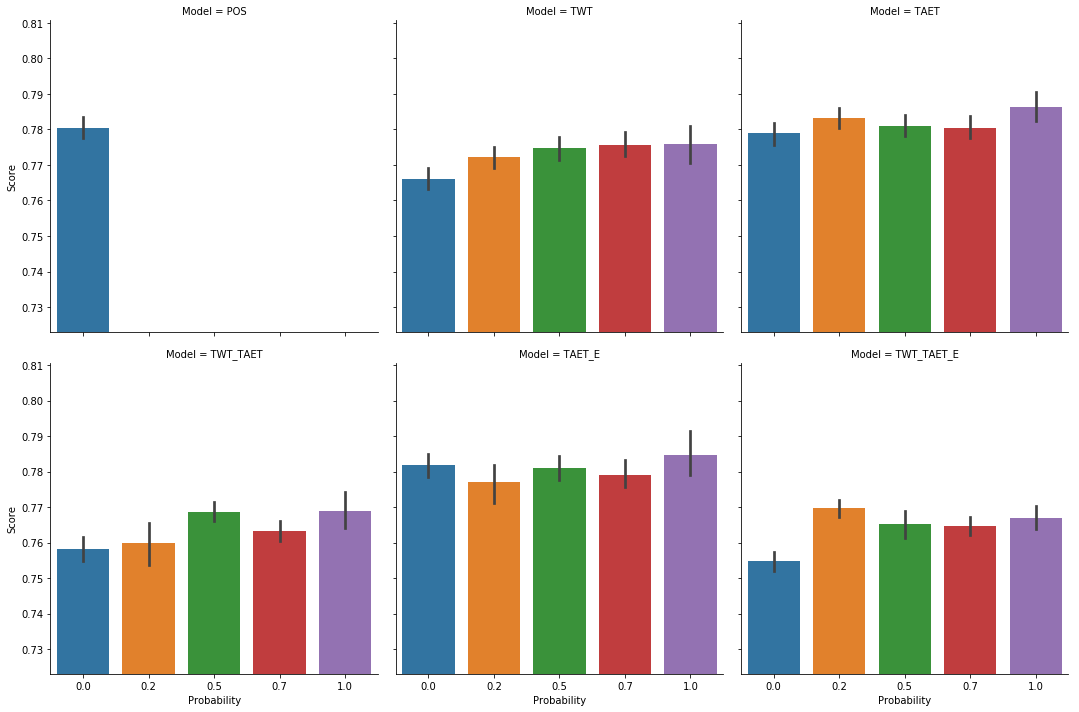

In [130]:
rest_results_prob = model_results_prob(restuarant_aug_collections, metrics)
plot_probability(rest_results_prob, metric='Acc', 
                 bar_plot=False, box_plot=False, cat_plot=True)

What to do next is to do the following:
1. Be able to plot the validation accuracy
2. Want to compare the best on the validation with each other
3. Probably want to plot over more probabilities
4. Want to compare the best probability with the original for the different sentiment categories
5. Try a different technique

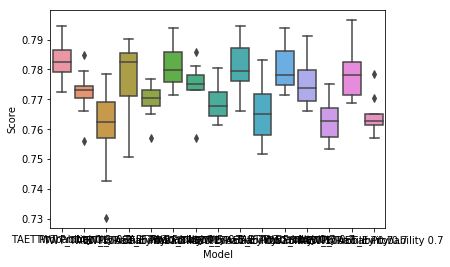

In [13]:
restaurant_predictions = domain_predictions(model_domain_predictions, 'restaurant')
restaurant_colls = dict_to_collection(restaurant_predictions, rest_test)

from sklearn.metrics import accuracy_score, f1_score
from bella.evaluation import datasets_df, plot_acc_f1
metrics = [('Accuracy', accuracy_score)]
res = datasets_df(restaurant_colls, metrics)
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
sns.boxplot(x='Model', y='Score', data=res)

In [15]:
restaurant_predictions = domain_predictions(model_domain_predictions, 'restaurant')
restaurant_colls = dict_to_collection(restaurant_predictions, rest_test)

from sklearn.metrics import accuracy_score, f1_score
from bella.evaluation import summary_errors
from bella.error_analysis import same_one_sentiment, same_multi_sentiment,\
                                 similar_sentiment, different_sentiment, unknown_targets
error_funcs = [('Same One', same_one_sentiment), ('Same Multi', same_multi_sentiment),
               ('Similar', similar_sentiment), ('Different', different_sentiment),
               ('Unknown', unknown_targets)]
metrics = [('Acc', accuracy_score)]
error_func_kwargs = {error_name: {'train_dataset': rest_train} for error_name, _ in error_funcs}
summary_errors(restaurant_colls, metrics=metrics,
               error_funcs=error_funcs, error_funcs_kwargs=error_func_kwargs)


,Same One,Same Multi,Similar,Different,Unknown
,Acc,Acc,Acc,Acc,Acc
TAET Probability 0.2,96.44,81.65,78.99,56.59,74.91
TWT Probability 0.2,96.00,81.08,78.99,57.05,71.99
TWT_TAET Probability 0.2,94.22,79.61,77.54,51.82,71.70
TAET_E Probability 0.2,95.56,81.68,77.98,56.82,74.01
TWT_TAET_E Probability 0.2,96.00,80.66,79.31,54.55,71.53
TAET Probability 0.5,94.00,81.35,79.28,58.86,74.23
TWT Probability 0.5,94.00,80.93,78.93,61.14,72.76
TWT_TAET Probability 0.5,92.44,80.93,78.61,56.82,71.82
TAET_E Probability 0.5,94.00,82.13,78.73,60.23,73.86


In [56]:
true = rest_test.sentiment_data()
a = model_domain_predictions['TAET Probability 0.2']['restaurant']
b = np.array(a)
from bella.data_types import TargetCollection
another = TargetCollection(rest_test.data(), name='TWT 0.7')
another.add_pred_sentiment(b.T)

In [57]:
from sklearn.metrics import accuracy_score, f1_score
np.mean(another.dataset_metric_scores(f1_score, average='macro'))

0.6757439072784288

In [55]:
np.mean(another.dataset_metric_scores(f1_score, average='macro'))

0.6670682384379305

In [53]:
np.mean(another.dataset_metric_scores(f1_score, average='macro'))

0.6681699955116985

In [47]:
np.mean(another.dataset_metric_scores(f1_score, average='macro'))

0.6525055204414827

In [49]:
np.mean(another.dataset_metric_scores(f1_score, average='macro'))

0.6600232964728401

In [51]:
np.mean(another.dataset_metric_scores(f1_score, average='macro'))

0.6577000935474204